In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import re
import os
import pickle
import numpy as np
import pandas as pd

In [5]:
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Dense, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, TimeDistributed, LSTM, Bidirectional, Reshape
from tensorflow.keras.layers import Embedding, Input, Dense, Conv2D, Reshape, MaxPooling2D, Flatten, Dropout

In [7]:
from sklearn.preprocessing import MinMaxScaler
from nltk import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse = False)
Lemmatizer = WordNetLemmatizer()
scaler = MinMaxScaler()
vectorizer = TfidfVectorizer(stop_words=None, token_pattern = r'(?u)\b\S+\b')

In [8]:
seed=69
tf.random.set_seed(seed)
np.random.seed(seed=seed)

In [207]:
#df = po.read_csv('training_data.csv').sample(frac=1)
#df = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/train_split.csv")
#val_df = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/val_split.csv")
#test_df = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/preprocessed_test_dataset.csv")

train_data = pd.read_csv("/content/drive/My Drive/CMCL 2021/Original Datasets/training_data.csv")
test_data = pd.read_csv("/content/drive/My Drive/CMCL 2021/Original Datasets/test_data.txt")

In [311]:
import seaborn as sns

targets = train_data.loc[:, ["nFix", "FFD", "GPT", "TRT", "fixProp"]]
corr = targets.corr()

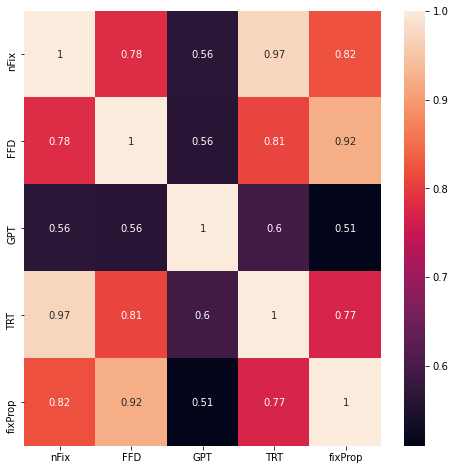

In [314]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))
sns.heatmap(corr, annot=True)

In [208]:
train_data

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294
...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778


In [209]:
test_data

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,800,0,It's,5.747126,1.384927,1.384927,1.783566,33.333333
1,800,1,the,14.942529,2.859205,4.398777,4.773360,66.666667
2,800,2,funniest,33.333333,3.312829,8.673838,10.175607,100.000000
3,800,3,American,36.781609,3.426235,9.340527,10.711708,100.000000
4,800,4,comedy,27.586207,3.694285,8.725386,8.660091,91.666667
...,...,...,...,...,...,...,...,...
3549,990,5,pursued,17.241379,4.412523,7.529468,5.185745,100.000000
3550,990,6,a,3.448276,1.030963,1.030963,1.030963,25.000000
3551,990,7,career,13.793103,3.113509,3.993264,3.515585,83.333333
3552,990,8,in,1.149425,0.254304,0.254304,0.254304,8.333333


In [214]:
df = train_data.copy()
test_df = test_data.copy()

In [211]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
keys = df.keys()[3:8]

b = scaler.fit_transform(df.loc[:, keys])     # Min Max scaling
b = pd.DataFrame(b, columns = keys)            
df.update(b)                                  # Updating values to Min max scaled values
c = scaler.transform(test_df.loc[:, keys])
c = pd.DataFrame(c, columns = keys)
test_df.update(c)

In [212]:
#df.to_csv("/content/drive/My Drive/CMCL Shared Task/MinMaxed_training_data", index = False)

In [213]:
#for col in ['nFix', 'FFD', 'GPT', 'TRT', 'fixProp']:
#  df[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min())

In [215]:
df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294
...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778


In [216]:
test_df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,800,0,It's,5.747126,1.384927,1.384927,1.783566,33.333333
1,800,1,the,14.942529,2.859205,4.398777,4.773360,66.666667
2,800,2,funniest,33.333333,3.312829,8.673838,10.175607,100.000000
3,800,3,American,36.781609,3.426235,9.340527,10.711708,100.000000
4,800,4,comedy,27.586207,3.694285,8.725386,8.660091,91.666667
...,...,...,...,...,...,...,...,...
3549,990,5,pursued,17.241379,4.412523,7.529468,5.185745,100.000000
3550,990,6,a,3.448276,1.030963,1.030963,1.030963,25.000000
3551,990,7,career,13.793103,3.113509,3.993264,3.515585,83.333333
3552,990,8,in,1.149425,0.254304,0.254304,0.254304,8.333333


In [217]:
def remove_eos(df, train = True):
  cnt = 1
  if not train:
    cnt = 801
  endword = []
  for i in range(df.shape[0]-1):
    if (df.loc[i+1, "sentence_id"] == cnt):
      df.loc[i, "word"] = df.loc[i, "word"][:-5]   # Remove <EOS> for the last word of each sentence.
      cnt += 1
      endword.append(1)
    else:
      endword.append(-1) 
  s = df.loc[df.shape[0] - 1, "word"]              # Remove <EOS> for last element separately
  df.loc[df.shape[0] - 1, "word"] = s[:-6] 
  endword.append(1)
  df["endword"] = endword
  return df

In [218]:
def char_per_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)))
  df["n_chars"] = n_chars
  return df

In [219]:
def char_per_lemmatized_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)) - len(Lemmatizer.lemmatize(word)))
  df["n_char_lemmatized"] = n_chars
  return df

In [220]:
#@title
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

stopwords = nltk.corpus.stopwords
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [221]:
def add_stopword_check(df):
  if_stopword = []
  for word in df.word:
    if word in stop_words:
      if_stopword.append(1)
    else:
      if_stopword.append(-1)

  df["stopword"] = if_stopword
  return df

In [222]:
def add_number_check(df):
  if_number = []
  for word in df.word:
    if_number.append(1 if word.isdigit() else -1)

  df["number"] = if_number
  return df

In [223]:
bad_words = []
punc = ",.;!"

def remove_punc(word):
  table = str.maketrans('', '', punc)
  return word.translate(table)

def calc_tfidf(df, train=True):
  start_pos = 0
  if not train:
    start_pos = 800
  n = np.array(df["sentence_id"])[-1]
  sentences = []
  tf_idfs = []
  MAX_LEN = 0
  for i in range(start_pos, n+1):   
    temp_df = df[df.sentence_id == i]
    sentence = (' ').join(np.array(temp_df.word))
    sentences.append(sentence)
    MAX_LEN = max(MAX_LEN, len(sentence.split()))
  print(sentences[:3])
  if train:
    tf_idf = vectorizer.fit_transform(sentences)
  else:
    tf_idf = vectorizer.transform(sentences)

  for i, word in enumerate(df.word):
    try:
      tf_idfs.append(tf_idf.toarray()[df["sentence_id"][i]- start_pos][vectorizer.get_feature_names().index(remove_punc(word.lower()))])
    except:
      bad_words.append(word)
      if word in ["a", "A", "I"]:
        tf_idfs.append(0.05)
      else:
        tf_idfs.append(TFIDF_ERROR)
  df["tf_idf"] = tf_idfs

  return sentences, df, bad_words

In [224]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

convert_dict = {"NNS":"NN",
                "PRP":"DT",
                "NN":"NN",
                "NNP":"NNP",
                "DT":"DT",
                "VB":"VB",
                "JJ":"JJ",
                "CD":"CD"}

def pos_tag_func(df, train=True):
  tags = []
  word_tag_tuple = nltk.pos_tag(df["word"])
  for word, tag in word_tag_tuple:
    if tag in convert_dict.keys():
      tags.append(convert_dict[tag]) 
    else:
      tags.append("unk")
  df["tags"] = tags
  
  if train:
    tag_transform = pd.DataFrame(enc.fit_transform(np.array(df.tags).reshape(-1, 1)))
  else:
    tag_transform = pd.DataFrame(enc.transform(np.array(df.tags).reshape(-1, 1)))
  df = pd.concat((df, tag_transform), axis = 1)
  return df

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [225]:
def preprocess(df, train = True):
  return calc_tfidf(pos_tag_func(add_number_check(add_stopword_check(char_per_lemmatized_word(char_per_word(remove_eos(df, train))))), train), train)


In [226]:
max_len = 65
num_feats = 13
num_outputs = 5
VOCAB_SIZE = 516783
TFIDF_ERROR = 0.1

In [227]:
sentences, df, bad_words = preprocess(df)
test_sentences, test_df, test_bad_words = preprocess(test_df, False)
df

['Carlucci was deputy defense secretary from 1981 until 1986, national security advisor from 1986 until 1987, and defense secretary in 1987, following the resignation of Weinberger, his nomination by President Ronald Reagan and his confirmation in the Senate by a vote of 91 to 1.', 'All members of the Bouvier family (except, of course, Marge) smoke heavily and have gruff voices and sarcastic, snarky demeanours.', "Genuinely touching because it's realistic about all kinds of love."]
["It's the funniest American comedy since Graffiti Bridge.", 'For a time in the summer of 1823, his expedition was joined by Italian explorer Giacomo Beltrami.', 'This method almost never fails him, and it works superbly here.']


,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647,-1,8,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.176250
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588,-1,3,1,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.059555
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000,-1,6,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.176250
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294,-1,7,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.306310
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294,-1,9,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.271369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222,-1,3,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.125612
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000,-1,7,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.482584
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778,-1,4,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.364676
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778,-1,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.131243


In [228]:
test_df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,800,0,It's,5.747126,1.384927,1.384927,1.783566,33.333333,-1,4,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.301302
1,800,1,the,14.942529,2.859205,4.398777,4.773360,66.666667,-1,3,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.106428
2,800,2,funniest,33.333333,3.312829,8.673838,10.175607,100.000000,-1,8,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.506531
3,800,3,American,36.781609,3.426235,9.340527,10.711708,100.000000,-1,8,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.297161
4,800,4,comedy,27.586207,3.694285,8.725386,8.660091,91.666667,-1,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.351511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,990,5,pursued,17.241379,4.412523,7.529468,5.185745,100.000000,-1,7,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.100000
3550,990,6,a,3.448276,1.030963,1.030963,1.030963,25.000000,-1,1,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.135377
3551,990,7,career,13.793103,3.113509,3.993264,3.515585,83.333333,-1,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.419793
3552,990,8,in,1.149425,0.254304,0.254304,0.254304,8.333333,-1,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.144474


In [229]:
import random

train_df = pd.DataFrame()
val_df = pd.DataFrame()

train_s = random.sample(range(0, 800), 640)
for s in train_s:
  train_df = pd.concat((train_df, df[df.sentence_id == s]), axis = 0)
for s in range(800):
  if s not in train_s:
    val_df = pd.concat((val_df, df[df.sentence_id == s]), axis = 0)

len(train_df), len(val_df)

(12522, 3214)

In [230]:
train_df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
4283,215,0,The,3.448276,0.622015,0.622015,1.398673,8.333333,-1,3,0,-1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.119309
4284,215,1,film,18.390805,4.481254,5.790577,8.646345,83.333333,-1,4,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.304841
4285,215,2,seems,37.931034,4.003574,8.790680,12.897350,91.666667,-1,5,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.511548
4286,215,3,a,8.045977,2.281865,2.955428,3.137565,50.000000,-1,1,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.150312
4287,215,4,dead,33.333333,4.570604,19.172480,12.072580,100.000000,-1,4,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.534909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5421,275,11,British,10.344828,3.072271,3.611808,3.611808,58.333333,-1,7,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.294083
5422,275,12,"actor,",17.241379,3.285336,7.144575,7.182377,75.000000,-1,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.251713
5423,275,13,writer,20.689655,4.003574,8.337056,8.897213,83.333333,-1,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.271337
5424,275,14,and,5.747126,1.835115,2.580845,2.347160,33.333333,-1,3,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.082982


In [231]:
val_df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
45,1,0,All,3.065134,0.744585,0.744585,0.744585,22.222222,-1,3,0,-1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.183892
46,1,1,members,16.858238,3.903914,4.985280,6.302622,83.333333,-1,7,1,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.235891
47,1,2,of,3.831418,0.762913,1.021799,1.026381,22.222222,-1,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.143394
48,1,3,the,6.896552,2.144404,2.144404,2.279574,44.444444,-1,3,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.058802
49,1,4,Bouvier,23.754789,5.141070,6.841014,9.720838,94.444444,-1,7,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.252119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15714,797,8,but,3.831418,1.189044,1.189044,1.189044,27.777778,-1,3,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.182280
15715,797,9,he,11.494253,3.530476,4.272770,3.942862,72.222222,-1,2,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.123361
15716,797,10,still,9.195402,2.911898,4.410232,3.209732,61.111111,-1,5,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.303263
15717,797,11,remains,18.390805,4.627880,7.956745,6.992222,94.444444,-1,7,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.303263


In [232]:
gbo = train_df.groupby('sentence_id')
sents = train_df['sentence_id'].unique()

val_gbo = val_df.groupby('sentence_id')
val_sents = val_df['sentence_id'].unique()

test_gbo = test_df.groupby("sentence_id")
test_sents = test_df["sentence_id"].unique()

In [233]:
len(sents), len(val_sents), len(test_sents)

(640, 160, 191)

In [234]:
df_s = pd.DataFrame()
sentences = []
o_sen_len = []
outputs = []
for s in sents[0:]:
  df_t = gbo.get_group(s)
  df_t = df_t.sort_values('word_id')
  words = df_t['word'].tolist()
  
  for i in range(len(words)):
    words[i] = re.sub("[^a-zA-Z]+|EOS", "", words[i]).lower()
  
  # Padding not req for tfidf
  #words = ["<PAD>"]*(max(max_len-len(words), 0)) + words[-max_len:]
  #assert len(words) == max_len
  
  sentences.append(" ".join(words))

  out = np.zeros((max_len, num_outputs))
  out[-min(max_len, len(df_t)):, :] = df_t.loc[:, ["nFix", "FFD", "TRT", "GPT", "fixProp"]].to_numpy()[-min(max_len, len(df_t)):, :]
  assert out.shape == (max_len, num_outputs)
  outputs.append(out)

In [235]:
val_df_s = pd.DataFrame()
val_sentences = []
val_o_sen_len = []
val_outputs = []
for s in val_sents[0:]:
  df_t = val_gbo.get_group(s)
  df_t = df_t.sort_values('word_id')
  words = df_t['word'].tolist()
  
  for i in range(len(words)):
    words[i] = re.sub("[^a-zA-Z]+|EOS", "", words[i]).lower()
  
  # Padding not req for tfidf
  #words = ["<PAD>"]*(max(max_len-len(words), 0)) + words[-max_len:]
  #assert len(words) == max_len
  
  val_sentences.append(" ".join(words))

  out = np.zeros((max_len, num_outputs))
  out[-min(max_len, len(df_t)):, :] = df_t.loc[:, ["nFix", "FFD", "GPT", "TRT", "fixProp"]].to_numpy()[-min(max_len, len(df_t)):, :]
  assert out.shape == (max_len, num_outputs)
  val_outputs.append(out)

In [236]:
test_df_s = pd.DataFrame()
test_sentences = []
test_o_sen_len = []
test_outputs = []
for s in test_sents:
  test_df_t = test_gbo.get_group(s)
  test_df_t = test_df_t.sort_values('word_id')
  words = test_df_t['word'].tolist()
  
  for i in range(len(words)):
    words[i] = re.sub("[^a-zA-Z]+|EOS", "", words[i]).lower()
  
  test_sentences.append(" ".join(words))
  out = np.zeros((max_len, num_outputs))
  out[-min(max_len, len(df_t)):, :] = df_t.loc[:, ["nFix", "FFD", "GPT", "TRT", "fixProp"]].to_numpy()[-min(max_len, len(df_t)):, :]
  assert out.shape == (max_len, num_outputs)
  test_outputs.append(out)

In [237]:
np.array(outputs).shape, np.array(val_outputs).shape, np.array(test_outputs).shape

((640, 65, 5), (160, 65, 5), (191, 65, 5))

In [238]:
#Original size of sentences before padding/truncation (mean, std, max)
#(19.638297872340427, 9.532269683187957, 65)

In [239]:
#Size after padding/truncation (mean, std, max)
#(19.58072590738423, 9.317816595444992, 50)
#np.mean(np.array(sen_len)), np.std(np.array(sen_len)), max(np.array(sen_len))

In [240]:
assert len(outputs) == len(sentences)

In [241]:
len(sentences), len(sentences[14].split(' '))

(640, 24)

In [242]:
outputs[14].shape

(65, 5)

In [243]:
outputs = np.array(outputs)
val_outputs = np.array(val_outputs)
test_outputs = np.array(test_outputs)

In [244]:
#@title
import zipfile
import gzip
import shutil

smaller_file_path = "/content/drive/My Drive/CMCL 2021/glove.6B.200d.txt"
numberbatch_file_path = "/content/drive/My Drive/CMCL 2021/numberbatch-en-19.08.txt.gz"


def load200GloveModel(File):
  print("Loading GloVe...")
  f = open(File,'r')
  gloveModel = {}
  for line in f:
      splitLines = line.split(' ')
      try:
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
      except:
        print("Error encountered. Skipping word ", word)
  print(len(gloveModel)," words loaded!")
  return gloveModel

def loadnumberbatch(File):
  print("Loading Number Batch...")

  print("Unzipping File...")
  with gzip.open(File, "rb") as f_in:
    with open('numberbatch.txt', 'wb') as f_out:
      shutil.copyfileobj(f_in, f_out)

  print("Finished unzipping File")

  f = open("numberbatch.txt", "r")
  netModel = {}
  for line in f:
      splitLines = line.split(' ')
      try:
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        netModel[word] = wordEmbedding
      except:
        print("Error encountered. Skipping word ", word)
  print(len(netModel)," words loaded!")
  return netModel


netModel = loadnumberbatch(numberbatch_file_path)
#glove_embedding_dict = load200GloveModel(smaller_file_path)

Loading Number Batch...
Unzipping File...
Finished unzipping File
516783  words loaded!


In [245]:
sentences[-1]

'john wells november    january   was a british actor writer and satirist'

In [246]:
train_df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
4283,215,0,The,3.448276,0.622015,0.622015,1.398673,8.333333,-1,3,0,-1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.119309
4284,215,1,film,18.390805,4.481254,5.790577,8.646345,83.333333,-1,4,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.304841
4285,215,2,seems,37.931034,4.003574,8.790680,12.897350,91.666667,-1,5,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.511548
4286,215,3,a,8.045977,2.281865,2.955428,3.137565,50.000000,-1,1,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.150312
4287,215,4,dead,33.333333,4.570604,19.172480,12.072580,100.000000,-1,4,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.534909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5421,275,11,British,10.344828,3.072271,3.611808,3.611808,58.333333,-1,7,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.294083
5422,275,12,"actor,",17.241379,3.285336,7.144575,7.182377,75.000000,-1,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.251713
5423,275,13,writer,20.689655,4.003574,8.337056,8.897213,83.333333,-1,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.271337
5424,275,14,and,5.747126,1.835115,2.580845,2.347160,33.333333,-1,3,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.082982


In [247]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)

In [248]:
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, 300)) # words not found in embedding index will be all-zeros.
for word, i in word_index.items():
  embedding_vector = netModel.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

GloVe = Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=True)

In [249]:
tok_sent = tokenizer.texts_to_sequences(sentences)
val_tok_sent = tokenizer.texts_to_sequences(val_sentences)
test_tok_sent = tokenizer.texts_to_sequences(test_sentences)

In [250]:
len(sentences), len(val_sentences), len(test_sentences)

(640, 160, 191)

In [251]:
pad_sent = pad_sequences(tok_sent, maxlen=max_len)
val_pad_sent = pad_sequences(val_tok_sent, maxlen=max_len)
test_pad_sent = pad_sequences(test_tok_sent, maxlen = max_len)

In [252]:
word_lens = []
lem_lens = []
tfidfs = []
stops = []
ends = []
nums = []
tag0s = []
tag1s = []    
tag2s = []
tag3s = []
tag4s = []
tag5s = []
tag6s = [] 

for i,sent in enumerate(sentences):
  lens = []
  lem_len = []
  tfidf = []
  stop = []
  end = []
  num = []
  tag0 = []
  tag1 = []    
  tag2 = []
  tag3 = []
  tag4 = []
  tag5 = []
  tag6 = [] 

  for j, word in enumerate(sent.split(' ')):
    lens.append(np.array(train_df["n_chars"])[i+j])
    lem_len.append(np.array(train_df["n_char_lemmatized"])[i+j])
    tfidf.append(np.array(train_df["tf_idf"])[i+j])
    stop.append(np.array(train_df["stopword"])[i+j])
    end.append(np.array(train_df["endword"])[i+j])
    num.append(np.array(train_df["number"])[i+j])
    tag0.append(np.array(train_df[0])[i+j])
    tag1.append(np.array(train_df[1])[i+j])    
    tag2.append(np.array(train_df[2])[i+j])
    tag3.append(np.array(train_df[3])[i+j])
    tag4.append(np.array(train_df[4])[i+j])
    tag5.append(np.array(train_df[5])[i+j])
    tag6.append(np.array(train_df[6])[i+j]) 


  lens = [0]*(max(max_len-len(lens), 0)) + lens[-max_len:]
  lem_len = [0]*(max(max_len-len(lem_len), 0)) + lem_len[-max_len:]
  tfidf = [0]*(max(max_len-len(tfidf), 0)) + tfidf[-max_len:]
  stop = [0]*(max(max_len-len(stop), 0)) + stop[-max_len:]
  end = [0]*(max(max_len-len(end), 0)) + end[-max_len:]
  num = [0]*(max(max_len-len(num), 0)) + num[-max_len:]
  tag0 = [0]*(max(max_len-len(tag0), 0)) + tag0[-max_len:]
  tag1 = [0]*(max(max_len-len(tag1), 0)) + tag1[-max_len:]
  tag2 = [0]*(max(max_len-len(tag2), 0)) + tag2[-max_len:]
  tag3 = [0]*(max(max_len-len(tag3), 0)) + tag3[-max_len:]
  tag4 = [0]*(max(max_len-len(tag4), 0)) + tag4[-max_len:]
  tag5 = [0]*(max(max_len-len(tag5), 0)) + tag5[-max_len:]
  tag6 = [0]*(max(max_len-len(tag6), 0)) + tag6[-max_len:]
   

  word_lens.append(lens)
  lem_lens.append(lem_len)  
  tfidfs.append(tfidf)
  stops.append(stop)
  ends.append(end)
  nums.append(num)
  tag0s.append(tag0)
  tag1s.append(tag1)
  tag2s.append(tag2)
  tag3s.append(tag3)
  tag4s.append(tag4)
  tag5s.append(tag5)
  tag6s.append(tag6)
    
val_word_lens = []
val_lem_lens = []
val_tfidfs = []
val_stops = []
val_ends = []
val_nums = []
val_tag0s = []
val_tag1s = []    
val_tag2s = []
val_tag3s = []
val_tag4s = []
val_tag5s = []
val_tag6s = [] 

for i,sent in enumerate(val_sentences):
  val_lens = []
  val_lem_len = []
  val_tfidf = []
  val_stop = []
  val_end = []
  val_num = []
  val_tag0 = []
  val_tag1 = []    
  val_tag2 = []
  val_tag3 = []
  val_tag4 = []
  val_tag5 = []
  val_tag6 = [] 

  for j, word in enumerate(sent.split(' ')):
    val_lens.append(np.array(val_df["n_chars"])[i+j])
    val_lem_len.append(np.array(val_df["n_char_lemmatized"])[i+j])
    val_tfidf.append(np.array(val_df["tf_idf"])[i+j])
    val_stop.append(np.array(val_df["stopword"])[i+j])
    val_end.append(np.array(val_df["endword"])[i+j])
    val_num.append(np.array(val_df["number"])[i+j])
    val_tag0.append(np.array(val_df[0])[i+j])
    val_tag1.append(np.array(val_df[1])[i+j])    
    val_tag2.append(np.array(val_df[2])[i+j])
    val_tag3.append(np.array(val_df[3])[i+j])
    val_tag4.append(np.array(val_df[4])[i+j])
    val_tag5.append(np.array(val_df[5])[i+j])
    val_tag6.append(np.array(val_df[6])[i+j]) 


  val_lens = [0]*(max(max_len-len(val_lens), 0)) + val_lens[-max_len:]
  val_lem_len = [0]*(max(max_len-len(val_lem_len), 0)) + val_lem_len[-max_len:]
  val_tfidf = [0]*(max(max_len-len(val_tfidf), 0)) + val_tfidf[-max_len:]
  val_stop = [0]*(max(max_len-len(val_stop), 0)) + val_stop[-max_len:]
  val_end = [0]*(max(max_len-len(val_end), 0)) + val_end[-max_len:]
  val_num = [0]*(max(max_len-len(val_num), 0)) + val_num[-max_len:]
  val_tag0 = [0]*(max(max_len-len(val_tag0), 0)) + val_tag0[-max_len:]
  val_tag1 = [0]*(max(max_len-len(val_tag1), 0)) + val_tag1[-max_len:]
  val_tag2 = [0]*(max(max_len-len(val_tag2), 0)) + val_tag2[-max_len:]
  val_tag3 = [0]*(max(max_len-len(val_tag3), 0)) + val_tag3[-max_len:]
  val_tag4 = [0]*(max(max_len-len(val_tag4), 0)) + val_tag4[-max_len:]
  val_tag5 = [0]*(max(max_len-len(val_tag5), 0)) + val_tag5[-max_len:]
  val_tag6 = [0]*(max(max_len-len(val_tag6), 0)) + val_tag6[-max_len:]
   

  val_word_lens.append(val_lens)
  val_lem_lens.append(val_lem_len)  
  val_tfidfs.append(val_tfidf)
  val_stops.append(val_stop)
  val_ends.append(val_end)
  val_nums.append(val_num)
  val_tag0s.append(val_tag0)
  val_tag1s.append(val_tag1)
  val_tag2s.append(val_tag2)
  val_tag3s.append(val_tag3)
  val_tag4s.append(val_tag4)
  val_tag5s.append(val_tag5)
  val_tag6s.append(val_tag6)
    





test_word_lens = []
test_lem_lens = []
test_tfidfs = []
test_stops = []
test_ends = []
test_nums = []
test_tag0s = []
test_tag1s = []    
test_tag2s = []
test_tag3s = []
test_tag4s = []
test_tag5s = []
test_tag6s = [] 

for i,sent in enumerate(test_sentences):
  test_lens = []
  test_lem_len = []
  test_tfidf = []
  test_stop = []
  test_end = []
  test_num = []
  test_tag0 = []
  test_tag1 = []    
  test_tag2 = []
  test_tag3 = []
  test_tag4 = []
  test_tag5 = []
  test_tag6 = [] 

  for j, word in enumerate(sent.split(' ')):
    test_lens.append(test_df["n_chars"][i+j])
    test_lem_len.append(test_df["n_char_lemmatized"][i+j])
    test_tfidf.append(test_df["tf_idf"][i+j])
    test_stop.append(test_df["stopword"][i+j])
    test_end.append(test_df["endword"][i+j])
    test_num.append(test_df["number"][i+j])
    test_tag0.append(test_df[0][i+j])
    test_tag1.append(test_df[1][i+j])    
    test_tag2.append(test_df[2][i+j])
    test_tag3.append(test_df[3][i+j])
    test_tag4.append(test_df[4][i+j])
    test_tag5.append(test_df[5][i+j])
    test_tag6.append(test_df[6][i+j]) 


  test_lens = [0]*(max(max_len-len(test_lens), 0)) + test_lens[-max_len:]
  test_lem_len = [0]*(max(max_len-len(test_lem_len), 0)) + test_lem_len[-max_len:]
  test_tfidf = [0]*(max(max_len-len(test_tfidf), 0)) + test_tfidf[-max_len:]
  test_stop = [0]*(max(max_len-len(test_stop), 0)) + test_stop[-max_len:]
  test_end = [0]*(max(max_len-len(test_end), 0)) + test_end[-max_len:]
  test_num = [0]*(max(max_len-len(test_num), 0)) + test_num[-max_len:]
  test_tag0 = [0]*(max(max_len-len(test_tag0), 0)) + test_tag0[-max_len:]
  test_tag1 = [0]*(max(max_len-len(test_tag1), 0)) + test_tag1[-max_len:]
  test_tag2 = [0]*(max(max_len-len(test_tag2), 0)) + test_tag2[-max_len:]
  test_tag3 = [0]*(max(max_len-len(test_tag3), 0)) + test_tag3[-max_len:]
  test_tag4 = [0]*(max(max_len-len(test_tag4), 0)) + test_tag4[-max_len:]
  test_tag5 = [0]*(max(max_len-len(test_tag5), 0)) + test_tag5[-max_len:]
  test_tag6 = [0]*(max(max_len-len(test_tag6), 0)) + test_tag6[-max_len:]
   

  test_word_lens.append(test_lens)
  test_lem_lens.append(test_lem_len)  
  test_tfidfs.append(test_tfidf)
  test_stops.append(test_stop)
  test_ends.append(test_end)
  test_nums.append(test_num)
  test_tag0s.append(test_tag0)
  test_tag1s.append(test_tag1)
  test_tag2s.append(test_tag2)
  test_tag3s.append(test_tag3)
  test_tag4s.append(test_tag4)
  test_tag5s.append(test_tag5)
  test_tag6s.append(test_tag6)
    


In [253]:
np.array(word_lens).shape, np.array(val_word_lens).shape, np.array(test_word_lens).shape

((640, 65), (160, 65), (191, 65))

In [254]:
l = []
s = []
for i in range(len(pad_sent)):
  l.append(np.stack([word_lens[i], lem_lens[i], tfidfs[i], ends[i], stops[i], nums[i], tag0s[i], tag1s[1], tag2s[i], tag3s[i], tag4s[i], tag5s[i], tag6s[i]], axis = 1))
  s.append(np.vstack([pad_sent[i]]).reshape(max_len, 1))

val_l = []
val_s = []
for i in range(len(val_pad_sent)):
  val_l.append(np.stack([val_word_lens[i], val_lem_lens[i], val_tfidfs[i], val_ends[i], val_stops[i], val_nums[i], val_tag0s[i], val_tag1s[1], val_tag2s[i], val_tag3s[i], val_tag4s[i], val_tag5s[i], val_tag6s[i]], axis = 1))
  val_s.append(np.vstack([val_pad_sent[i]]).reshape(max_len, 1))


test_l = []
test_s = []
for i in range(len(test_pad_sent)):
  test_l.append(np.stack([test_word_lens[i], test_lem_lens[i], test_tfidfs[i], test_ends[i], test_stops[i], test_nums[i], test_tag0s[i], test_tag1s[1], test_tag2s[i], test_tag3s[i], test_tag4s[i], test_tag5s[i], test_tag6s[i]], axis = 1))
  test_s.append(np.vstack([test_pad_sent[i]]).reshape(max_len, 1))

In [255]:
X_feat = np.array(l, dtype = "float")
X_val_feat = np.array(val_l, dtype = "float")
X_test_feat = np.array(test_l, dtype = "float")

X_sent = np.array(s)
X_val_sent = np.array(val_s)
X_test_sent = np.array(test_s)

In [256]:
X_feat.shape, X_val_feat.shape, X_test_feat.shape

((640, 65, 13), (160, 65, 13), (191, 65, 13))

In [257]:
"""
X_train 	= pad_sent[:int(0.6*len(pad_sent))]#.reshape(-1, max_len, 1)
X_val 		= pad_sent[int(0.6*len(pad_sent)):int(0.8*len(pad_sent))]#.reshape(-1, max_len, 1)
X_test 		= pad_sent[int(0.8*len(pad_sent)):]#.reshape(-1, max_len, 1)
X_train.shape, X_val.shape, X_test.shape
"""

'\nX_train \t= pad_sent[:int(0.6*len(pad_sent))]#.reshape(-1, max_len, 1)\nX_val \t\t= pad_sent[int(0.6*len(pad_sent)):int(0.8*len(pad_sent))]#.reshape(-1, max_len, 1)\nX_test \t\t= pad_sent[int(0.8*len(pad_sent)):]#.reshape(-1, max_len, 1)\nX_train.shape, X_val.shape, X_test.shape\n'

In [258]:
#X_train_feat 	= X_feat[:int(0.8*len(X_feat))]#.reshape(-1, max_len, 1)
#X_train_sent 	= X_sent[:int(0.8*len(X_sent))]#.reshape(-1, max_len, 1)

#X_val_feat = X_feat[int(0.8*len(X_sent)):int(1*len(X_feat))]#.reshape(-1, max_len, 1)
#X_val_sent = X_sent[int(0.8*len(X_sent)):int(1*len(X_sent))]#.reshape(-1, max_len, 1)

X_feat.shape, X_val_feat.shape, X_test_feat.shape, X_sent.shape, X_val_sent.shape, X_test_sent.shape

((640, 65, 13),
 (160, 65, 13),
 (191, 65, 13),
 (640, 65, 1),
 (160, 65, 1),
 (191, 65, 1))

In [259]:
y_train 	= outputs
y_val 		= val_outputs
y_test = test_outputs
y_train.shape, y_val.shape, y_test.shape

((640, 65, 5), (160, 65, 5), (191, 65, 5))

In [260]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices("GPU")

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [261]:
X_feat.shape

(640, 65, 13)

In [262]:
#X_feat[0]

In [315]:
with tf.device("CPU:0"):
  sequence_input = Input(shape=(max_len, 1), dtype='int32')
  feature_input = Input(shape=(max_len, num_feats), dtype = "float64")

  x1 = GloVe(sequence_input[:, :, 0])
  x1 = Bidirectional(LSTM(256, return_sequences=True))(x1)
  x1 = Bidirectional(LSTM(256, return_sequences=True))(x1)
  x1 = Bidirectional(LSTM(256, return_sequences=True))(x1)
  x1 = TimeDistributed(Dense(128, activation='relu'))(x1)

  #x2 = feature_input
  x2 = Bidirectional(LSTM(256, return_sequences=True))(feature_input)
  x2 = Bidirectional(LSTM(256, return_sequences=True))(x2)
  x2 = Bidirectional(LSTM(256, return_sequences=True))(x2)
  x2 = TimeDistributed(Dense(128, activation='relu'))(x2)

  z = (x1+x2)/2
  z = Bidirectional(LSTM(128, return_sequences=True))(z)
  z = TimeDistributed(Dense(5, activation = "relu"))(z)


In [316]:
"""
sequence_input = Input(shape=(max_len), dtype='int32')
x = GloVe(sequence_input)
x = Conv1D(kernel_size=10, filters=64, padding='same', activation='tanh')(x)
x = Conv1D(kernel_size=10, filters=64, padding='same', activation='tanh')(x)
x = Conv1D(kernel_size=10, filters=64, padding='same', activation='tanh')(x)
x = Dropout(0.2)(x)
x = Dense(5, activation='sigmoid')(x)
"""

"\nsequence_input = Input(shape=(max_len), dtype='int32')\nx = GloVe(sequence_input)\nx = Conv1D(kernel_size=10, filters=64, padding='same', activation='tanh')(x)\nx = Conv1D(kernel_size=10, filters=64, padding='same', activation='tanh')(x)\nx = Conv1D(kernel_size=10, filters=64, padding='same', activation='tanh')(x)\nx = Dropout(0.2)(x)\nx = Dense(5, activation='sigmoid')(x)\n"

In [317]:
model = Model([sequence_input, feature_input], z)
optimizer = tf.keras.optimizers.Adam(lr=4e-5, beta_1=0.9, beta_2=0.999)
model.compile(loss='MAE', optimizer=optimizer, metrics=['mean_squared_error'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 65, 1)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, 65)           0           input_9[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 65, 300)      1165200     tf.__operators__.getitem_4[0][0] 
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 65, 13)]     0                                            
____________________________________________________________________________________________

In [318]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='bilstm_best_model.hdf5', monitor='val_mean_squared_error', save_best_only=True, save_weights_only=True)

In [319]:
hist = model.fit(x = [X_sent, X_feat], y = y_train, validation_data=([X_val_sent, X_val_feat], y_val), epochs=150, batch_size=16, callbacks=[earlystop, model_checkpoint], shuffle=False)


Epoch 1/150
40/40 [==============================] - 22s 195ms/step - loss: 5.8264 - mean_squared_error: 337.4712 - val_loss: 5.7508 - val_mean_squared_error: 340.1709
Epoch 2/150
40/40 [==============================] - 4s 100ms/step - loss: 5.5674 - mean_squared_error: 331.3470 - val_loss: 5.4840 - val_mean_squared_error: 334.5833
Epoch 3/150
40/40 [==============================] - 4s 99ms/step - loss: 5.3368 - mean_squared_error: 325.8851 - val_loss: 5.3248 - val_mean_squared_error: 331.4569
Epoch 4/150
40/40 [==============================] - 4s 98ms/step - loss: 5.1571 - mean_squared_error: 322.5486 - val_loss: 5.1179 - val_mean_squared_error: 315.6157
Epoch 5/150
40/40 [==============================] - 4s 100ms/step - loss: 4.9189 - mean_squared_error: 296.2069 - val_loss: 4.8581 - val_mean_squared_error: 279.7641
Epoch 6/150
40/40 [==============================] - 4s 100ms/step - loss: 4.6340 - mean_squared_error: 262.1791 - val_loss: 4.5695 - val_mean_squared_error: 257.4347

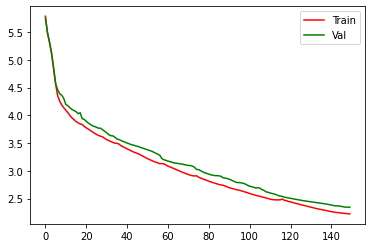

In [320]:
import matplotlib.pyplot as plt

plt.plot(hist.history["loss"], c = "r", label = "Train")
plt.plot(hist.history["val_loss"], c = "g", label = "Val")
plt.legend()
plt.show()

In [321]:
hist.history["loss"][0], hist.history["val_loss"][0], hist.history["loss"][-1], hist.history["val_loss"][-1] 

(5.785801887512207, 5.750845432281494, 2.223464250564575, 2.344660758972168)

In [322]:
y_train_pred = model.predict(x = [X_sent, X_feat])
y_val_pred = model.predict([X_val_sent, X_val_feat])
y_test_pred = model.predict([X_test_sent, X_test_feat])

In [323]:
y_train_pred.shape, y_train.shape, y_val_pred.shape, y_val.shape, y_test_pred.shape, y_test.shape

((640, 65, 5),
 (640, 65, 5),
 (160, 65, 5),
 (160, 65, 5),
 (191, 65, 5),
 (191, 65, 5))

In [324]:
X_train_s = np.stack([X_sent[:,:,0], X_sent[:,:,0], X_sent[:,:,0], X_sent[:,:,0], X_sent[:,:,0]], axis=2)
X_val_s = np.stack([X_val_sent[:,:,0], X_val_sent[:,:,0], X_val_sent[:,:,0], X_val_sent[:,:,0], X_val_sent[:,:,0]], axis=2)
X_test_s = np.stack([X_test_sent[:,:,0], X_test_sent[:,:,0], X_test_sent[:,:,0], X_test_sent[:,:,0], X_test_sent[:,:,0]], axis=2)

In [325]:
X_train_s.shape, X_val_s.shape, X_test_s.shape

((640, 65, 5), (160, 65, 5), (191, 65, 5))

In [326]:
#y_train_pred[0]

In [327]:
y_train_pred = np.where(X_train_s==0, 0, y_train_pred)
y_val_pred = np.where(X_val_s==0, 0, y_val_pred)
y_test_pred = np.where(X_test_s==0, 0, y_test_pred)

In [328]:
#y_train_pred[0]

In [329]:
non_zeros = np.count_nonzero(word_lens[0], axis = 0)
train_temp = y_train_pred[0][-non_zeros:].tolist()
#train_temp

In [330]:
non_zeros = np.count_nonzero(word_lens[0], axis = 0)
train_temp2 = y_train[0][-non_zeros:].tolist()
train_temp2

[[3.4482758620689653,
  0.6220145022165711,
  1.3986734939344996,
  0.6220145022165711,
  8.333333333333332],
 [18.39080459770115,
  4.481253651328225,
  8.646345235231452,
  5.7905769957730495,
  83.33333333333334],
 [37.93103448275862,
  4.003574005979587,
  12.897350424413213,
  8.790680092099386,
  91.66666666666666],
 [8.045977011494253,
  2.281865356197808,
  3.1375648647719854,
  2.9554280215814983,
  50.0],
 [33.33333333333333,
  4.5706038008178975,
  12.072579813739305,
  19.172480153957178,
  100.0],
 [14.94252873563218,
  4.395340046049693,
  6.536307089590707,
  16.966218770404485,
  75.0]]

In [331]:
#X_val_s = np.stack([X_val_sent[:,:,0], X_val_sent[:,:,0], X_val_sent[:,:,0], X_val_sent[:,:,0], X_val_sent[:,:,0]], axis=2)
#y_val_pred = np.where(X_val_s==0, 0, y_val_pred)

In [332]:
X_sent.shape, y_train_pred.shape

((640, 65, 1), (640, 65, 5))

In [333]:
train_pred = []
train_y = []
for i,x in enumerate(word_lens):
  non_zeros = np.count_nonzero(x, axis = 0)
  train_pred += y_train_pred[i][-non_zeros:].tolist()
  train_y += y_train[i][-non_zeros:].tolist()

val_pred = []
val_y = []
for i,x in enumerate(val_word_lens):
  non_zeros = np.count_nonzero(x, axis = 0)
  val_pred += y_val_pred[i][-non_zeros:].tolist()
  val_y += y_val[i][-non_zeros:].tolist()

test_pred = []
test_y = []
for i,x in enumerate(test_word_lens):
  non_zeros = np.count_nonzero(x, axis = 0)
  test_pred += y_test_pred[i][-non_zeros:].tolist()
  test_y += y_test[i][-non_zeros:].tolist()

In [334]:
train_pred[0]

[1.0470532178878784,
 0.352018266916275,
 0.15728212893009186,
 0.4919384717941284,
 6.43638277053833]

In [335]:
np.array(train_pred).shape, np.array(val_pred).shape, np.array(test_pred).shape

((12522, 5), (3214, 5), (3554, 5))

In [288]:
y_train_pred = scaler.inverse_transform(train_pred)
y_val_pred = scaler.inverse_transform(val_pred)
y_test_pred = scaler.inverse_transform(test_pred)

train_y = scaler.inverse_transform(train_y)
val_y = scaler.inverse_transform(val_y)
test_y = scaler.inverse_transform(test_y)

In [336]:
y_train_pred = np.array(train_pred)
y_val_pred = np.array(val_pred)
y_test_pred = np.array(test_pred)

train_y = np.array(train_y)
val_y = np.array(val_y)
test_y = np.array(test_y)

In [337]:
r2_scores = []
for i in range(5):
  #print(r2_score(train_y[:, i], y_train_pred[:, i]))
  r2_scores.append(r2_score(train_y[:, i], y_train_pred[:, i]))

print("\n\n")
val_r2_scores = []
for i in range(5):
  #print(r2_score(val_y[:, i], y_val_pred[:, i]))
  val_r2_scores.append(r2_score(val_y[:, i], y_val_pred[:, i]))

print("\n\n")
test_r2_scores = []
for i in range(5):
  #print(r2_score(test_y[:, i], y_test_pred[:, i]))
  test_r2_scores.append(r2_score(test_y[:, i], y_test_pred[:, i]))

In [338]:
r2_scores = [r2_scores]
val_r2_scores = [val_r2_scores]
test_r2_scores = [test_r2_scores]

In [339]:
display = pd.concat((pd.DataFrame(r2_scores, columns = ["nFix", "FFD", "TRT", "GPT", "fixProp"]), pd.DataFrame(val_r2_scores, columns = ["nFix", "FFD", "TRT", "GPT", "fixProp"]), pd.DataFrame(test_r2_scores, columns = ["nFix", "FFD", "TRT", "GPT", "fixProp"])), axis = 0)
display

,nFix,FFD,TRT,GPT,fixProp
0,-0.060363,-0.052004,-0.047806,0.060523,-0.185966
0,-0.786846,-1.220482,-0.224481,-0.640795,-1.703342
0,-0.173276,-0.032222,0.082356,-0.168792,0.064646


In [180]:
from sklearn.metrics import mean_absolute_error

mae_scores = []
for i in range(5):
  #print(mean_absolute_error(train_y[:, i], y_train_pred[:, i]))
  mae_scores.append(mean_absolute_error(train_y[:, i], y_train_pred[:, i]))

print("\n\n")
val_mae_scores = []
for i in range(5):
  #print(mean_absolute_error(val_y[:, i], y_val_pred[:, i]))
  val_mae_scores.append(mean_absolute_error(val_y[:, i], y_val_pred[:, i]))

print("\n\n")
test_mae_scores = []
for i in range(5):
  #print(mean_absolute_error(test_y[:, i], y_test_pred[:, i]))
  test_mae_scores.append(mean_absolute_error(test_y[:, i], y_test_pred[:, i]))

In [181]:
mae_scores = [mae_scores]
val_mae_scores = [val_mae_scores]
test_mae_scores = [test_mae_scores]

In [182]:
display2 = pd.concat((pd.DataFrame(mae_scores, columns = ["nFix", "FFD", "TRT", "GPT", "fixProp"]), pd.DataFrame(val_mae_scores, columns = ["nFix", "FFD", "TRT", "GPT", "fixProp"]), pd.DataFrame(test_mae_scores, columns = ["nFix", "FFD", "TRT", "GPT", "fixProp"])), axis = 0)
display2

,nFix,FFD,TRT,GPT,fixProp
0,7.230131,1.186236,6.925777,1.255637,21.886862
0,9.121022,1.644439,5.548287,4.056076,31.976335
0,5.818735,1.324841,5.321095,2.050470,27.081891


In [154]:
np.mean(r2_scores), np.mean(val_r2_scores), np.std(val_r2_scores), np.max(val_r2_scores), np.min(val_r2_scores)

(-0.09026477737771758,
 -0.9732740513290349,
 0.3808571834548326,
 -0.36599591623048533,
 -1.4782790084357202)

In [ ]:
r2 = [r2_scores, val_r2_scores]
pd.DataFrame(r2)

In [ ]:
pd.DataFrame([[np.mean(val_r2_scores), np.std(val_r2_scores), np.max(val_r2_scores), np.min(val_r2_scores)]])

In [ ]:
y_pred = model.predict([X_test_sent, X_test_feat])

In [ ]:
y_pred.shape

In [ ]:
model.save("/content/drive/My Drive/CMCL Shared Task/BiLSTM_Feat_28_minmax.h5")

In [ ]:
#(test_tok_sent)

In [ ]:
predictions = np.zeros((3554, 5))
row = 0
for i in range(800, 991):
  t = test_gbo.get_group(i)
  t = t.sort_values("word_id")
  length = len(t["word"].tolist())
  predictions[row:row+length] = y_pred[i-800][-length:]
  row+=length
predictions

In [ ]:
predictions = np.array(predictions)

In [ ]:
final_predictions = scaler.inverse_transform(predictions)

In [ ]:
final_predictions

In [ ]:
final_df = pd.DataFrame(final_predictions, columns = ["nFix", "FFD","TRT","GPT", "fixProp"])
final_df

In [ ]:
#final_df["GPT"] = final_df["TRT"] - final_df["GPT"]
final_df

In [ ]:
final_df = final_df.loc[:, ["nFix", "FFD", "GPT", "TRT", "fixProp"]]
final_df

In [ ]:
final_df.median(axis = 0)

In [ ]:
train_data.median(axis = 0)

In [ ]:
test_dataset = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/test_data.csv")
words=[]
for word in test_dataset.word:
  w = re.sub(",", "", word)
  words.append(w)

submission = pd.concat((test_dataset, final_df), axis = 1)
submission["word"] = words
submission 

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,800,0,It's,19.202538,3.933204,2.010786,18.453719,81.802934
1,800,1,the,16.568750,3.488761,2.119858,15.580356,80.168110
2,800,2,funniest,15.712619,3.468776,2.105318,14.395644,79.525274
3,800,3,American,24.402079,4.556641,3.435580,23.404862,93.833828
4,800,4,comedy,19.254260,4.212871,3.033159,17.649931,89.907324
...,...,...,...,...,...,...,...,...
3549,990,5,pursued,12.498450,3.296626,1.950725,10.502074,75.797355
3550,990,6,a,6.798383,1.936288,1.066780,5.790689,42.761660
3551,990,7,career,19.289827,4.289670,3.206245,17.021899,89.691830
3552,990,8,in,8.704437,2.576377,2.310335,8.002753,55.491847


In [ ]:
pwd

'/content'

In [ ]:
submission.to_csv("/content/drive/My Drive/CMCL Shared Task/minmax_numbatch_BiLSTM_submission2.csv", index = False)

In [ ]:
submission.to_csv("answer_minmax_numbatch_BiLSTM_submission.txt")

In [ ]:
s = ''
for column in submission.columns:
  s += str(column)
  s += ","
s = s[:-1]
s += "\n"
with open("/content/drive/My Drive/CMCL Shared Task/Submission_Roberta_21.txt", 'w') as f:
    v = ''
    f.write(s)
    x = submission.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
    vals = [','.join(ele.split()) for ele in x]
    for val in vals:
      v += str(val)
      v += "\n"
    f.write(
        v
    )
    f.close()
